## Import Packages

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import kerastuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import Model
import os

## Setting Parameters

In [7]:
# Coefficient of Variation
COV = 3.5

In [32]:
# Model Parameters
num_neurons_per_layer = 100
hidden_layers = 2
activation_function = "relu"
l2_regularization = 0.00001
optimizer = "adam"
loss = "SCCE"

In [42]:
# Training Parameters
epochs = 30

## Loading Data

In [8]:
%%time
train = pd.read_csv("./datasets/cov_filtered_" + str(COV) + "_training.csv", index_col = 0)
validation = pd.read_csv("./datasets/cov_filtered_" + str(COV) + "_validation.csv", index_col = 0)

dataset_sizes = pd.read_csv("subset sizes.csv", header = None)

# Labels -> numbers
labels = pd.read_csv("labels.csv")
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,1]] = i
train["Classification"].replace(labels_dict, inplace=True)
validation["Classification"].replace(labels_dict, inplace=True)

CPU times: user 2.16 s, sys: 500 ms, total: 2.66 s
Wall time: 2.73 s


In [37]:
input_size = train.shape[1] - 1
x_train = train.iloc[:, 1:size]
y_train = train.iloc[:, [size]]
x_val = validation.iloc[:,1:size]
y_val = validation.iloc[:,[size]]

## Defining Useful Functions

In [38]:
def ModelSameLayer(size, neurons, hls = 2, activ = "relu", l2reg = None, optimizer = 'adam', loss = "SCCE"):
    model = tf.keras.Sequential()
    reg_val = l2reg
    if l2reg != None:
        reg_val = regularizers.l2(l2reg) 
    if loss == "SCCE":
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.add(Dense(neurons, input_shape=(size - 1,), activation = activ, kernel_regularizer = reg_val))
    for i in range(1, hls + 1):
        model.add(Dense(neurons, activation = activ, kernel_regularizer = reg_val))
    model.add(Dense(75))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [39]:
def PredictionTable(predictions):
    y_pred = []
    for pred in predictions:
        y_pred.append(np.argmax(pred))
    cm = pd.DataFrame(metrics.confusion_matrix(y_val, y_pred))
    new_cm = pd.DataFrame(columns = ["TN", "FP", "FN", "TP"])
    for i in range(75):
        true_negative = 0
        for j in range(75):
            if j == i:
                continue
            true_negative += sum(cm[j][0:i].append(cm[j][i+1:]))
        new_cm.loc[i] = [true_negative, sum(cm[i][0:i].append(cm[i][i+1:])), sum(cm.iloc[i][0:i].append(cm.iloc[i][i+1:])), cm[i][i]]
    cm = new_cm
    cm["TN"] = cm["TN"].astype(np.int64)
    cm["FP"] = cm["FP"].astype(np.int64)
    cm["FN"] = cm["FN"].astype(np.int64)
    cm["TP"] = cm["TP"].astype(np.int64)
    cm = cm.assign(precision = cm["TP"] / (cm["TP"] + cm["FP"]))
    cm["precision"].astype(np.float64)
    cm = cm.assign(recall = cm["TP"] / (cm["TP"] + cm["FN"]))
    cm["recall"].astype(np.float64)
    cm = cm.assign(f1 = 2 * 1 / ((1 / cm["precision"]) + (1 / cm["recall"])))
    cm = cm.assign(fbeta = (1 + 0.5 ** 2) * (cm["precision"] * cm["recall"]) / ((0.5 ** 2 * cm["precision"]) + cm["recall"]))
    cm["fbeta"].fillna(0, inplace=True)
    cm["cluster"] = labels["Cluster"]
    cm = cm.merge(dataset_sizes, how = 'inner', left_on='cluster', right_on=0)
    cm.drop(columns=0, inplace = True)
    cm.rename(columns={1:"size"}, inplace = True)
    cm["log_size"] = np.log2(cm["size"])
    return cm

## Model Training

Epoch 1/30
293/293 [==============================] - 1s 3ms/step - loss: 0.9550 - val_loss: 0.4454
Epoch 2/30
293/293 [==============================] - 1s 2ms/step - loss: 0.2129 - val_loss: 0.3360
Epoch 3/30
293/293 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.3519
Epoch 4/30
293/293 [==============================] - 1s 2ms/step - loss: 0.0748 - val_loss: 0.2858
Epoch 5/30
293/293 [==============================] - 1s 2ms/step - loss: 0.0471 - val_loss: 0.3279
Epoch 6/30
293/293 [==============================] - 1s 2ms/step - loss: 0.0304 - val_loss: 0.4932
Epoch 7/30
293/293 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.3436
Epoch 8/30
293/293 [==============================] - 1s 2ms/step - loss: 0.0576 - val_loss: 0.3672
Epoch 9/30
293/293 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.4232
2 x 100 relu 1e-05


(0.0, 1.5)

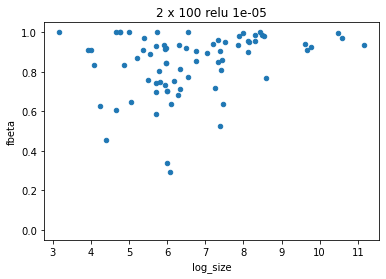

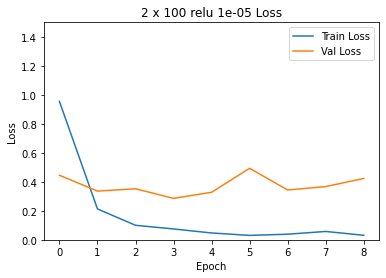

In [43]:
fbeta_dict = {}

model = ModelSameLayer(input_size, num_neurons_per_layer, hidden_layers, activation_function, 
                       l2_regularization, optimizer, loss)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=callback)


predictions = tf.nn.softmax(model.predict(x_val)).numpy()
cm = PredictionTable(predictions)

fbeta_dict[activation_function] = []
fbeta_dict[activation_function].extend(list(cm["fbeta"]))

Title = str(hidden_layers) + " x " +str(num_neurons_per_layer) + " " + activation_function + " " + str(l2_regularization)

print(Title)
fig = cm.plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05], title=Title).get_figure()
# path = "Plots/" + Title + ".png"
# plt.savefig(path)
# Loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(Title + " Loss")
plt.legend(loc="best")
plt.ylim(0, 1.5)
# path = "Plots/" + Title + " Loss.png"
# plt.savefig(path)